In [ ]:
import pandas as pd

# Loading the Dataset
data_url = "https://drive.google.com/uc?export=download&id=1ZmhK-IBtXts9GPvJ2IS2Uwaddf9VMzsO"

df_helper = pd.read_csv(data_url)

image_directory = './data/'

!gdown --id 1rZALsup6DJwR2JpDWyWHNvU_aptUcQjp

!unzip -q RSNA-516.zip -d ./data/


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1rZALsup6DJwR2JpDWyWHNvU_aptUcQjp
From (redirected): https://drive.google.com/uc?id=1rZALsup6DJwR2JpDWyWHNvU_aptUcQjp&confirm=t&uuid=6a51fd48-16dc-40da-8603-0a95b608fb50
To: /content/RSNA-516.zip
100% 3.76G/3.76G [01:52<00:00, 33.3MB/s]


In [ ]:
# Construct the image_path column dynamically
df_helper['image_path'] = '/content/data/' + df_helper['patient_id'].astype(str) + '_' + df_helper['image_id'].astype(str) + '.png'


In [ ]:
df = df_helper[['image_path', 'cancer']]

df

,image_path,cancer
0,/content/data/10006_462822612.png,0
1,/content/data/10006_1459541791.png,0
2,/content/data/10006_1864590858.png,0
3,/content/data/10006_1874946579.png,0
4,/content/data/10011_220375232.png,0
...,...,...
54701,/content/data/9973_1729524723.png,0
54702,/content/data/9989_63473691.png,0
54703,/content/data/9989_1078943060.png,0
54704,/content/data/9989_398038886.png,0


New distribution of 'cancer' column:
cancer
0    2316
1    1158
Name: count, dtype: int64


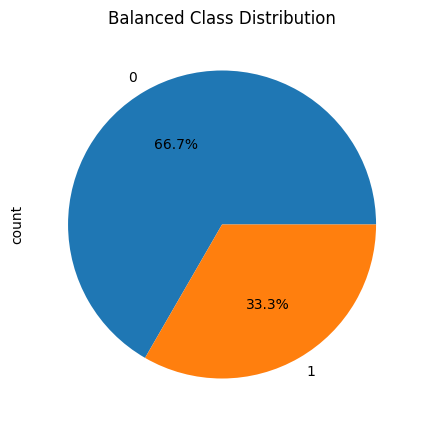

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get indices for all cancer cases
indices_cancer = df[df['cancer'] == 1].index

# Get indices for non-cancer cases
indices_not_cancer = df[df['cancer'] == 0].index

# Randomly sample twice the number of cancer cases from the non-cancer cases
indices_not_cancer_sampled = np.random.choice(indices_not_cancer, 2 * len(indices_cancer), replace=False)

# Concatenate the indices of cancer and sampled non-cancer cases
balanced_indices = np.concatenate([indices_cancer, indices_not_cancer_sampled])

# Create a new DataFrame with balanced cases
df_balanced = df.loc[balanced_indices]

# Check the class distribution in the new DataFrame
print("New distribution of 'cancer' column:")
print(df_balanced['cancer'].value_counts())

# Plot pie chart to visualize the new class distribution
df_balanced['cancer'].value_counts().plot.pie(autopct='%.1f%%', figsize=(5, 5))
plt.title('Balanced Class Distribution')
plt.show()


<ipython-input-8-67433884230f>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(row['image_path'])
<ipython-input-8-67433884230f>:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(row['image_path'])


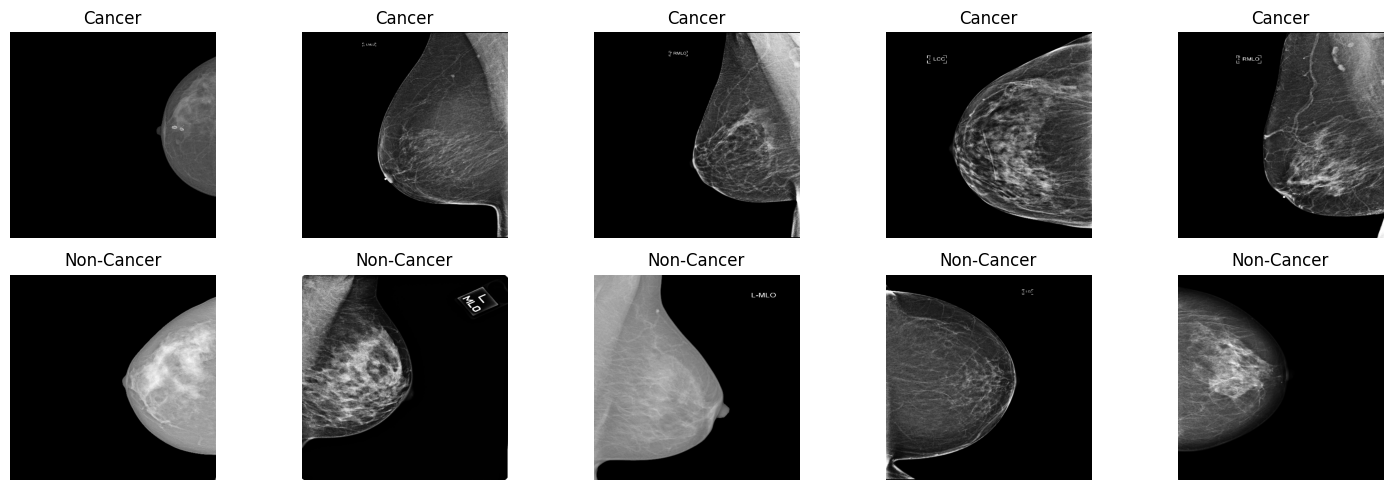

In [ ]:
import matplotlib.pyplot as plt
from imageio import imread
import numpy as np
import pandas as pd

# Filter images based on cancer_label
cancer_images = df_balanced[df_balanced['cancer'] == 1].sample(5)  # Select 5 cancer images randomly
non_cancer_images = df_balanced[df_balanced['cancer'] == 0].sample(5)  # Select 5 non-cancer images randomly

# Plotting cancer images
plt.figure(figsize=(15, 5))
for i, (index, row) in enumerate(cancer_images.iterrows()):
    plt.subplot(2, 5, i + 1)
    img = imread(row['image_path'])
    plt.imshow(img, cmap='gray')  # Apply grayscale colormap here
    plt.title('Cancer')
    plt.axis('off')

# Plotting non-cancer images
for i, (index, row) in enumerate(non_cancer_images.iterrows()):
    plt.subplot(2, 5, 5 + i + 1)
    img = imread(row['image_path'])
    plt.imshow(img, cmap='gray')  # Apply grayscale colormap here
    plt.title('Non-Cancer')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load image data from paths and convert to grayscale
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=1)  # Decode image as grayscale
    img = tf.image.resize(img, [224, 224])  # Resize to the network's input size
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img

# Split the data into training, validation, and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(
    df_balanced['image_path'], df_balanced['cancer'],
    test_size=0.3, random_state=42, stratify=df_balanced['cancer']
)

# Further split the validation/test set
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test,
    test_size=0.5, random_state=42, stratify=y_val_test
)

# Convert paths to actual images using the load_image function
X_train = np.array([load_image(path) for path in X_train])
X_val = np.array([load_image(path) for path in X_val])
X_test = np.array([load_image(path) for path in X_test])

def apply_gaussian_blur(image):
    # Check the number of channels in the image and adjust the kernel accordingly
    num_channels = image.shape[-1] if len(image.shape) > 2 else 1
    kernel_size = 5
    eye_kernel = tf.eye(kernel_size)
    blur_kernel = tf.cast(eye_kernel, tf.float32)
    blur_kernel = tf.tile(blur_kernel[:, :, tf.newaxis, tf.newaxis], [1, 1, num_channels, 1])
    blur_kernel = blur_kernel / tf.reduce_sum(blur_kernel)  # Normalize the kernel

    image = tf.expand_dims(image, 0)  # Add batch dimension
    image = tf.nn.depthwise_conv2d(image, blur_kernel, strides=[1, 1, 1, 1], padding='SAME')
    image = tf.squeeze(image, 0)  # Remove batch dimension
    return image

# Configure data augmentation with Gaussian blur
train_datagen = ImageDataGenerator(
    preprocessing_function=apply_gaussian_blur,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the data generator to the training data
train_datagen.fit(X_train)




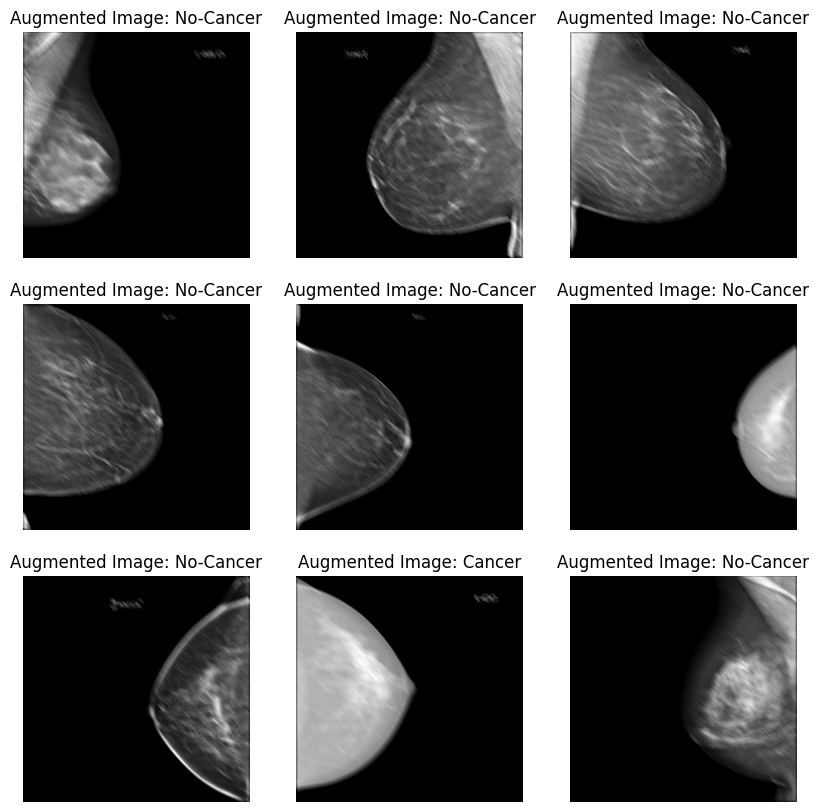

In [ ]:
# Generate augmented images for visualization
augmented_images, augmented_labels = next(train_datagen.flow(X_train, y_train, batch_size=9))

plt.figure(figsize=(10, 10))
for i in range(9):  # Display 9 images
    ax = plt.subplot(3, 3, i + 1)
    # If the images are grayscale, ensure they're displayed correctly
    if augmented_images[i].shape[-1] == 1:
        display_image = augmented_images[i].squeeze()  # Remove the channel dimension
    else:
        display_image = augmented_images[i]
    plt.imshow(display_image, cmap='gray')
    plt.title('Augmented Image: ' + ('Cancer' if augmented_labels[i] == 1 else 'No-Cancer'))
    plt.axis('off')
plt.show()


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import save_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Define directories for saving images
base_dir = '/content/balanced_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Create directories if they do not exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Load and preprocess image function
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)  # Use decode_jpeg for JPEG images if needed
    img = tf.image.resize(img, [224, 224])  # Resize to the required size
    img = img / 255.0  # Normalize pixel values
    return img

# Load dataset paths and labels
# Assuming df_balanced['image_path'] and df_balanced['cancer'] are defined
X_train, X_val_test, y_train, y_val_test = train_test_split(
    df_balanced['image_path'], df_balanced['cancer'],
    test_size=0.3, random_state=42, stratify=df_balanced['cancer']
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test,
    test_size=0.5, random_state=42, stratify=y_val_test
)

def process_and_save_images(X, y, directory):
    # Class-specific subdirectories
    class_dirs = {0: 'no_cancer', 1: 'cancer'}
    for i, path in enumerate(X):
        img = load_image(path)
        img = tf.image.convert_image_dtype(img, tf.uint8)  # Convert for saving
        # Determine the class subdirectory
        class_dir = class_dirs[y.iloc[i]]
        full_dir = os.path.join(directory, class_dir)
        os.makedirs(full_dir, exist_ok=True)  # Ensure class directory exists
        filename = f'image_{i}.png'
        save_img(os.path.join(full_dir, filename), img.numpy())


# Process and save images
process_and_save_images(X_train, y_train, train_dir)
process_and_save_images(X_val, y_val, val_dir)
process_and_save_images(X_test, y_test, test_dir)

# Data generators for training, validation, and testing (using processed images from directory)
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Load data from directories and ensure generators are working with directory paths
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)


Found 2431 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 522 images belonging to 2 classes.


In [ ]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Load pre-trained EfficientNetB0, modify it by adding custom layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:-40]:
    layer.trainable = False

# Adding new layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.55)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with specified learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Assume train_generator and val_generator are already defined
# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_scores = model.evaluate(val_generator)
print("Validation Loss:", val_scores[0])
print("Validation Accuracy:", val_scores[1])


Epoch 1/15
102/102 [==============================] - 25s 115ms/step - loss: 0.6601 - accuracy: 0.6277 - val_loss: 0.6489 - val_accuracy: 0.6660
Epoch 2/15
102/102 [==============================] - 9s 85ms/step - loss: 0.6445 - accuracy: 0.6524 - val_loss: 0.6392 - val_accuracy: 0.6641
Epoch 3/15
102/102 [==============================] - 8s 77ms/step - loss: 0.6395 - accuracy: 0.6545 - val_loss: 0.6339 - val_accuracy: 0.6641
Epoch 4/15
102/102 [==============================] - 10s 102ms/step - loss: 0.6262 - accuracy: 0.6639 - val_loss: 0.6286 - val_accuracy: 0.6641
Epoch 5/15
102/102 [==============================] - 8s 78ms/step - loss: 0.6243 - accuracy: 0.6656 - val_loss: 0.6247 - val_accuracy: 0.6622
Epoch 6/15
102/102 [==============================] - 8s 81ms/step - loss: 0.6180 - accuracy: 0.6660 - val_loss: 0.6223 - val_accuracy: 0.6641
Epoch 7/15
102/102 [==============================] - 10s 93ms/step - loss: 0.6079 - accuracy: 0.6738 - val_loss: 0.6195 - val_accuracy: 0

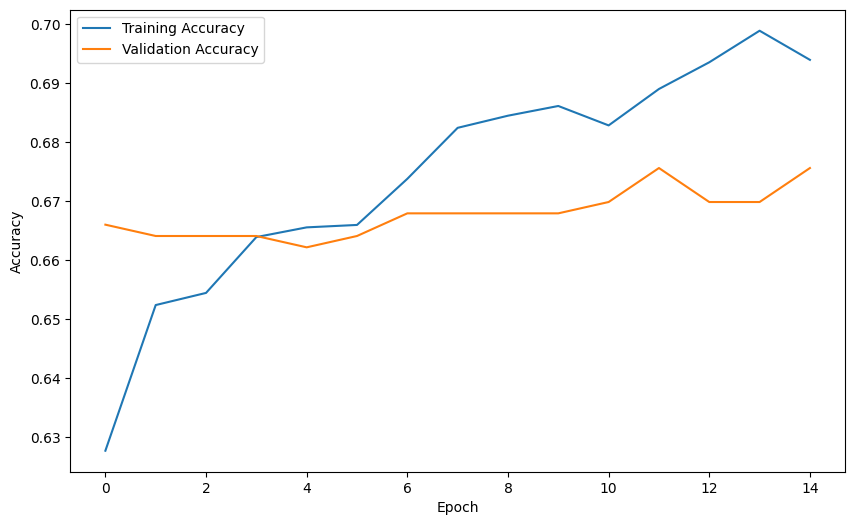

In [ ]:
# plot learning

# Plot the training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Epoch 1/15
102/102 [==============================] - 11s 105ms/step - loss: 0.5728 - accuracy: 0.6985 - val_loss: 0.6051 - val_accuracy: 0.6718
Epoch 2/15
102/102 [==============================] - 10s 94ms/step - loss: 0.5696 - accuracy: 0.7038 - val_loss: 0.6052 - val_accuracy: 0.6718
Epoch 3/15
102/102 [==============================] - 8s 78ms/step - loss: 0.5759 - accuracy: 0.6964 - val_loss: 0.6050 - val_accuracy: 0.6699
Epoch 4/15
102/102 [==============================] - 9s 89ms/step - loss: 0.5697 - accuracy: 0.7022 - val_loss: 0.6049 - val_accuracy: 0.6699
Epoch 5/15
102/102 [==============================] - 10s 96ms/step - loss: 0.5704 - accuracy: 0.7051 - val_loss: 0.6049 - val_accuracy: 0.6699
Epoch 6/15
102/102 [==============================] - 8s 82ms/step - loss: 0.5684 - accuracy: 0.7055 - val_loss: 0.6047 - val_accuracy: 0.6718
Epoch 7/15
102/102 [==============================] - 10s 97ms/step - loss: 0.5692 - accuracy: 0.6931 - val_loss: 0.6045 - val_accuracy: 0

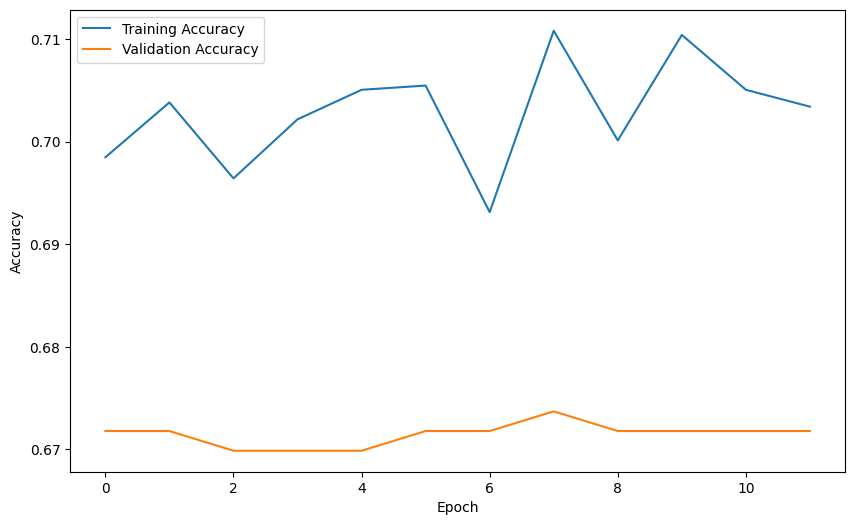

In [ ]:

# Reduce the learning rate by a factor of 10
new_lr = 0.00001 / 10

# Update the learning rate for the optimizer
model.optimizer.lr.assign(new_lr)

# Continue training the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_scores = model.evaluate(val_generator)
print("Validation Loss:", val_scores[0])
print("Validation Accuracy:", val_scores[1])

# Plot the training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
